In [1]:
%matplotlib inline

import datacube
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
import xarray as xr
import warnings
warnings.filterwarnings('ignore')

sys.path.append("../Scripts")
from dea_plotting import display_map
from dea_plotting import rgb
from dea_datahandling import load_ard

In [2]:
dc = datacube.Datacube(app="Chlorophyll")

In [4]:
# Define an area of interest
lat = (-32.423, -32.523)
lon = (142.180, 142.280)

# Set the range of dates for the analysis
time = ('2017-06-01','2019-06-01')

In [5]:
display_map(x=lon, y=lat)

In [6]:

# Choose products to load
# Here, the Sentinel-2a and Sentinel-2b products are chosen
products = ["s2a_ard_granule", "s2b_ard_granule"]

# Specify the parameters to pass to the load query
query = {
    "x": longitude,
    "y": latitude,
    "time": time,
    "measurements": [
        "nbart_red_edge_1",  # Red edge 1 band
        "nbart_red",  # Red band
        "nbart_green",  # Green band
        "nbart_blue",  # Blue band
        "nbart_nir_1",  # Near-infrared band
        "nbart_swir_2",  # Short wave infrared band
    ],
    "output_crs": "EPSG:3577",
    "resolution": (-20, 20)
}

# Load the data
ds_s2 = load_ard(dc, products=products, min_gooddata=0.7, **query)

Loading s2a_ard_granule data
    Filtering to 40 out of 85 observations
    Applying pixel quality mask
Loading s2b_ard_granule data
    Filtering to 42 out of 89 observations
    Applying pixel quality mask
Combining and sorting data
Masking out invalid values
    Returning 82 observations 


In [7]:
print(ds_s2)

<xarray.Dataset>
Dimensions:           (time: 82, x: 510, y: 596)
Coordinates:
  * y                 (y) float64 -3.572e+06 -3.572e+06 ... -3.584e+06
  * x                 (x) float64 9.477e+05 9.478e+05 ... 9.579e+05 9.579e+05
  * time              (time) datetime64[ns] 2017-06-03T00:27:11.026000 ... 2019-05-24T00:27:11.024000
Data variables:
    nbart_red_edge_1  (time, y, x) float32 1569.0 1777.0 ... 1275.0 1199.0
    nbart_red         (time, y, x) float32 1228.0 1486.0 ... 1102.0 1102.0
    nbart_green       (time, y, x) float32 641.0 755.0 852.0 ... 906.0 888.0
    nbart_blue        (time, y, x) float32 375.0 402.0 473.0 ... 750.0 723.0
    nbart_nir_1       (time, y, x) float32 2192.0 2426.0 ... 1498.0 1452.0
    nbart_swir_2      (time, y, x) float32 3092.0 3458.0 ... 1788.0 1714.0
Attributes:
    crs:      EPSG:3577


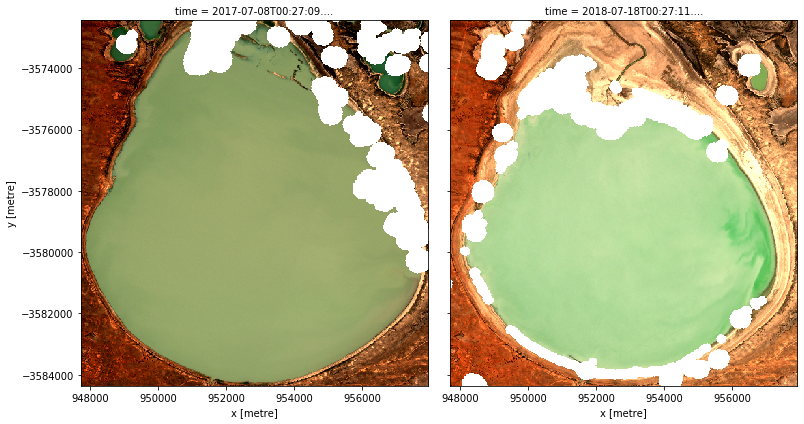

In [8]:
# Set the timesteps to visualise
t1 = 1
t43 = 43

# Generate RGB plots at each timestep
rgb(ds_s2,index=[t1,t43])

In [11]:
# Calculate MNDWI and add it to the loaded data set
ds_s2['MNDWI'] = ((ds_s2.nbart_green - ds_s2.nbart_swir_2)/
                 (ds_s2.nbart_green + ds_s2.nbart_swir_2))

# Calculate NDCI and add it to the loaded data set
ds_s2['NDCI'] = ((ds_s2.nbart_red_edge_1 - ds_s2.nbart_red) /
                 (ds_s2.nbart_red_edge_1 + ds_s2.nbart_red))

In [12]:
print(ds_s2)

<xarray.Dataset>
Dimensions:           (time: 82, x: 510, y: 596)
Coordinates:
  * y                 (y) float64 -3.572e+06 -3.572e+06 ... -3.584e+06
  * x                 (x) float64 9.477e+05 9.478e+05 ... 9.579e+05 9.579e+05
  * time              (time) datetime64[ns] 2017-06-03T00:27:11.026000 ... 2019-05-24T00:27:11.024000
Data variables:
    nbart_red_edge_1  (time, y, x) float32 1569.0 1777.0 ... 1275.0 1199.0
    nbart_red         (time, y, x) float32 1228.0 1486.0 ... 1102.0 1102.0
    nbart_green       (time, y, x) float32 641.0 755.0 852.0 ... 906.0 888.0
    nbart_blue        (time, y, x) float32 375.0 402.0 473.0 ... 750.0 723.0
    nbart_nir_1       (time, y, x) float32 2192.0 2426.0 ... 1498.0 1452.0
    nbart_swir_2      (time, y, x) float32 3092.0 3458.0 ... 1788.0 1714.0
    MNDWI             (time, y, x) float32 -0.65657645 -0.6415856 ... -0.3174481
    NDCI              (time, y, x) float32 0.12191634 ... 0.042155586
Attributes:
    crs:      EPSG:3577


In [14]:
# Constants for calculating waterbody area
pixel_length = query['resolution'][1] # in metres
m_per_km = 1000 # conversion from metres to kilometres
print(pixel_length)

area_per_pixel = pixel_length**2/m_per_km**2

20


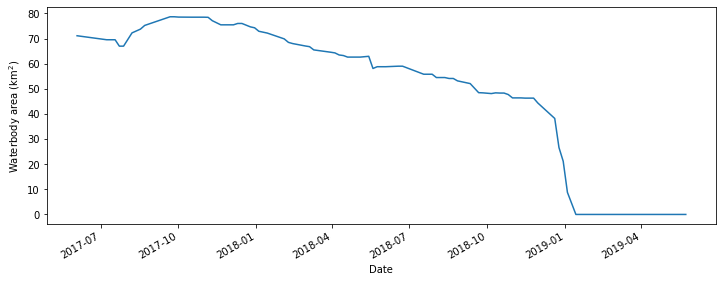

In [15]:
# Filter the data to contain only pixels classified as water
ds_s2_waterarea = ds_s2.where(ds_s2.MNDWI>0.0)

# Calculate the total water area (in km2)
waterarea = (
    ds_s2_waterarea.MNDWI.count(dim=['x','y'])
    .rolling(time=3,center=True,min_periods=1)
    .median(skipna=True)
    * area_per_pixel
)

# Plot the resulting water area  through time
fig, axes = plt.subplots(1,1,figsize=(12,4))
waterarea.plot()
axes.set_xlabel('Date')
axes.set_ylabel('Waterbody area (km$^2$)')
plt.show()

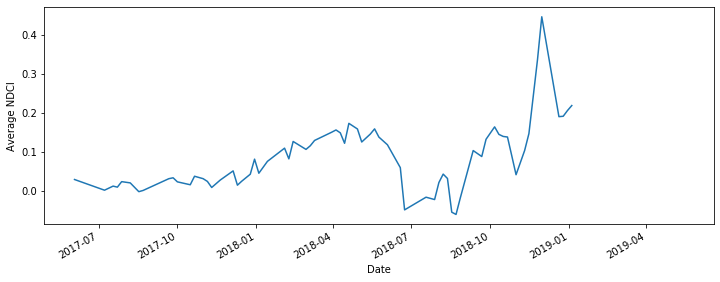

In [16]:
# Calculate the average NDCI
average_ndci = ds_s2_waterarea.NDCI.mean(dim=['x','y'],skipna=True)

# Plot average NDCI through time
fig, axes = plt.subplots(1,1,figsize=(12,4))
average_ndci.plot()
axes.set_xlabel('Date')
axes.set_ylabel('Average NDCI')
plt.show()